In [12]:
import pandas as pd
import os
import json
import openai
import backoff
from PIL import Image
import pickle
import time

In [13]:
file_path = os.path.join("data", "books_set", "captions.json")

with open(file_path, 'rb') as file:
    captions_data = json.load(file)

In [14]:
OPENAI_API_PATH = os.path.join(os.getcwd(), 'api.key')

with open(OPENAI_API_PATH) as f:
    openai.api_key = f.read().strip()

@backoff.on_exception(backoff.expo, openai.OpenAIError)
def completions_with_backoff(**kwargs):
    return openai.chat.completions.create(**kwargs)

def gpt(user_prompt, system_prompt="You are an expert pathologist", model="gpt-4", temperature=0.7, max_tokens=1000) -> list:

    messages = [{"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}]
    
    res = completions_with_backoff(model=model, messages=messages, temperature=temperature, max_tokens=max_tokens)
    
    return res.choices[0].message.content

In [15]:
base_prompt = '''You are provided with a text description (figure caption) of a pathology image. Unfortunately, you don't have access to the original image.
Your job is to generate a total of 5 open-ended question/answer pairs from this figure caption starting with "What" or "Where". Below are the requirements to generate the question/answer pairs:

- Avoid quoting or referring to specific facts, terms, abbreviations, dates, numbers or names, as these may reveal the conversation is based on the text information, rather than image itself.
- Focus on the visual aspects of the image that can be inferred without the text information
- Do not use phrases like "mentioned", "caption", "context", "without the image" in the question/answer pairs. Instead, refer to the information as being "in the image" or preferably don't mention anything
- Ensure that question/anwer pairs are diverse and cover a range of visual aspects of the image
- Answer responsibly, avoiding overconfidence, and do not provide medical advice or diagnostic information

Caption: {caption}
Question:
Answer:
'''

In [16]:
# Getting the results and saving it
index_list = []
figure_id_list = []
letter_list = []
caption_list = []
uuid_list = []
llm_response_list = []

start_index = 0
current_index = start_index
total_records = len(captions_data)

while True:
    try:
        for index in range(start_index, total_records):
            current_index = index
            figure_id = captions_data[str(current_index)]['figure_id']
            letter = captions_data[str(current_index)]['letter']
            caption = captions_data[str(current_index)]['caption']
            uuid = captions_data[str(current_index)]['uuid']
            
            user_prompt = base_prompt.format(caption = caption)
            response = gpt(user_prompt)
            
            index_list.append(current_index)
            figure_id_list.append(figure_id)
            letter_list.append(letter)
            caption_list.append(caption)
            uuid_list.append(uuid)
            llm_response_list.append(response)

            print("Index:", current_index)
            print("Figure_ID:", figure_id)
            print("Letter:", letter)
            print("Caption:", caption)
            print("UUID:", uuid)
            print()
            print(response)
            print()
    
    except Exception as err:
        print("Something went wrong: ", err)
        start_index = current_index
        print("Waiting for 10 seconds before continuing again with index:", start_index)
        time.sleep(10)

    # Break the loop if current_index has completed
    if current_index == (total_records - 1):
        break

llm_qa_pairs_books = pd.DataFrame({'index': index_list, 'figure_id': figure_id_list, 'letter': letter_list,
                                   'caption': caption_list, 'uuid': uuid_list, 'llm_qa_pairs_books': llm_response_list})

file_name = 'llm_qa_pairs_books_' + str(start_index) + '_' + str(total_records) + '.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(llm_qa_pairs_books, file)

Index: 0
Figure_ID: 00
Letter: A
Caption:  A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma.
UUID: 890e2e79-ab0a-4a2e-9d62-b0b6b3d43884

Question: What type of cell morphology can be observed in the image?
Answer: The image likely displays spindle-shaped cells, which are a characteristic of certain types of tumors.

Question: What is the visual appearance of the cells in the image?
Answer: The cells in the image likely have a prominent eosinophilic appearance, meaning they are stained bright pink or red.

Question: What distinctive feature might some cells in the image show?
Answer: Some cells in the image might show prominent paranuclear vacuolisation, which is a clear or empty space around the nucleus of the cell.

Question: Where can we observe the fascicles of eosinophilic spindle cells in the image?
Answer: The fascicles of eos

Caption:   A, Spindle cell variant of embryonal rhabdomyosarcoma is characterized by fascicles of eosinophilic spindle cells (B), some of which can show prominent paranuclear vacuolisation, as seen in leiomyosarcoma. 

Question: What general shape do the cells in the image have?
Answer: The cells in this image are spindle-shaped, resembling elongated ovals.

Question: What is the color tone of the spindle cells?
Answer: The spindle cells in the image have an eosinophilic, or pinkish, coloration.

Question: Where in the cells might one observe a particular feature, such as prominent paranuclear vacuolisation?
Answer: Prominent paranuclear vacuolisation can be observed in some of the spindle cells. This feature is typically found close to the cell nucleus, giving it its 'paranuclear' name.

Question: What pattern is formed by the arrangement of the spindle cells in the image?
Answer: The spindle cells are arranged in a pattern known as fascicles, appearing in bundled or grouped formation

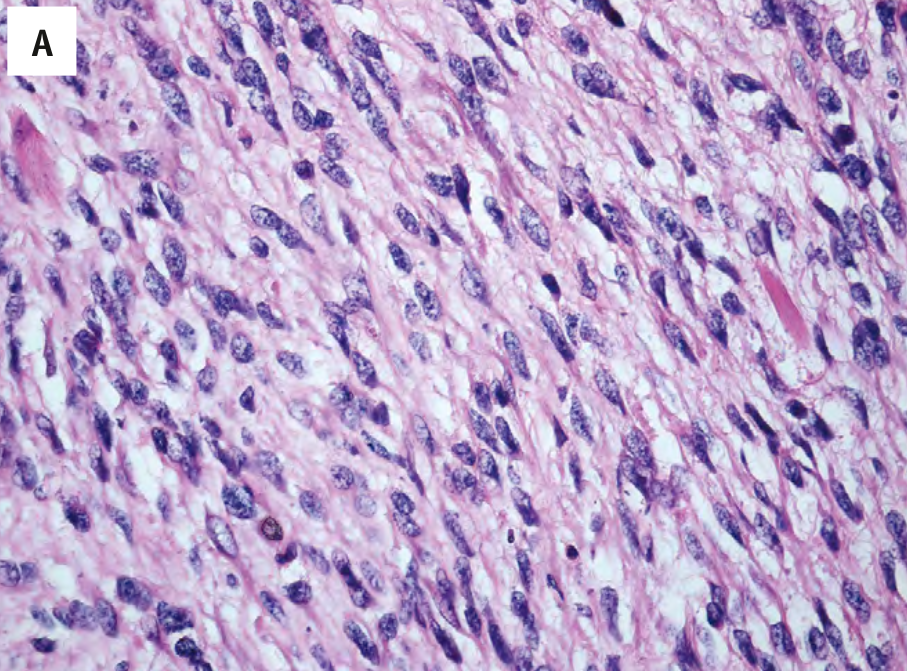

In [7]:
id = 0
caption = captions_data[str(id)]['caption']
uuid = captions_data[str(id)]['uuid']
img_path = os.path.join("data", "books_set", "images", uuid + ".png")
img = Image.open(img_path)

user_prompt = base_prompt.format(caption = caption)
res = gpt(user_prompt)
print("Caption: ", caption, "\n")
print(res)
img